# Phân loại bình luận tích cực và tiêu cực trên các quán ăn

In [169]:
import pandas as pd
import string
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

import warnings as wrn
wrn.filterwarnings('ignore')

In [170]:
df = pd.read_csv('small_data.csv')
df['Label'] = df['Point'].apply(lambda point: 0 if point >= 6  else 1)
sentences = df['Review'].tolist()
joined_sentences = " ".join(sentences)

## Khai phá dữ liệu

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8456 entries, 0 to 8455
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  8456 non-null   object 
 1   Point   8456 non-null   float64
 2   Label   8456 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 198.3+ KB


In [172]:
df.describe()

,Point,Label
count,8456.000000,8456.000000
mean,7.272233,0.161542
std,1.959571,0.368052
min,1.000000,0.000000
25%,6.800000,0.000000
50%,7.800000,0.000000
75%,8.400000,0.000000
max,10.000000,1.000000


In [173]:
df

,Review,Point,Label
0,"Cháo ếch đậm đà, cơm thì không đặc sắc mấy. \n...",7.4,0
1,Quán này mình cũng hay order lắm. Menu quán cũ...,7.8,0
2,Cháo thịt bò 30k\n------\nĐang mệt người vì th...,8.0,0
3,"Shinshu đã chuyển qua nguỹen hoàng, vị trí cũn...",8.0,0
4,"Chất lượng : Menu đa dạng , nhiều lựa chọn , t...",8.2,0
...,...,...,...
8451,Đc lái xe giới thiệu cho ăn nhưng cảm thấy cũn...,6.6,0
8452,Quán ăn mình search trên mạng \nQuán khá nôi t...,7.8,0
8453,Là 1 quán nổi tiếng về mì quảng nhưng so với t...,7.2,0
8454,Khá ngon.,7.6,0


[Text(0.5, 1.0, 'Số lượng mẫu')]

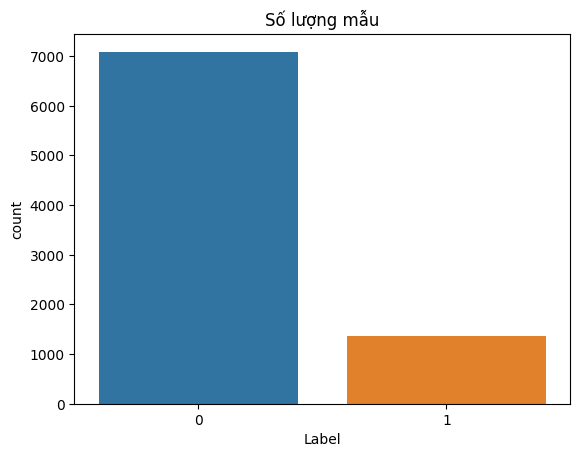

In [174]:
sns.countplot(data=df, x='Label').set(title='Số lượng mẫu')

### WordCloud trước khi tiền xử lý

- <i>WordCloud của tất cả các review</i>

In [175]:
def plot_wordcloud(sentences):
    plt.figure(figsize=(20, 20))
    wordcloud = WordCloud(max_words=200, background_color='white').generate(sentences)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

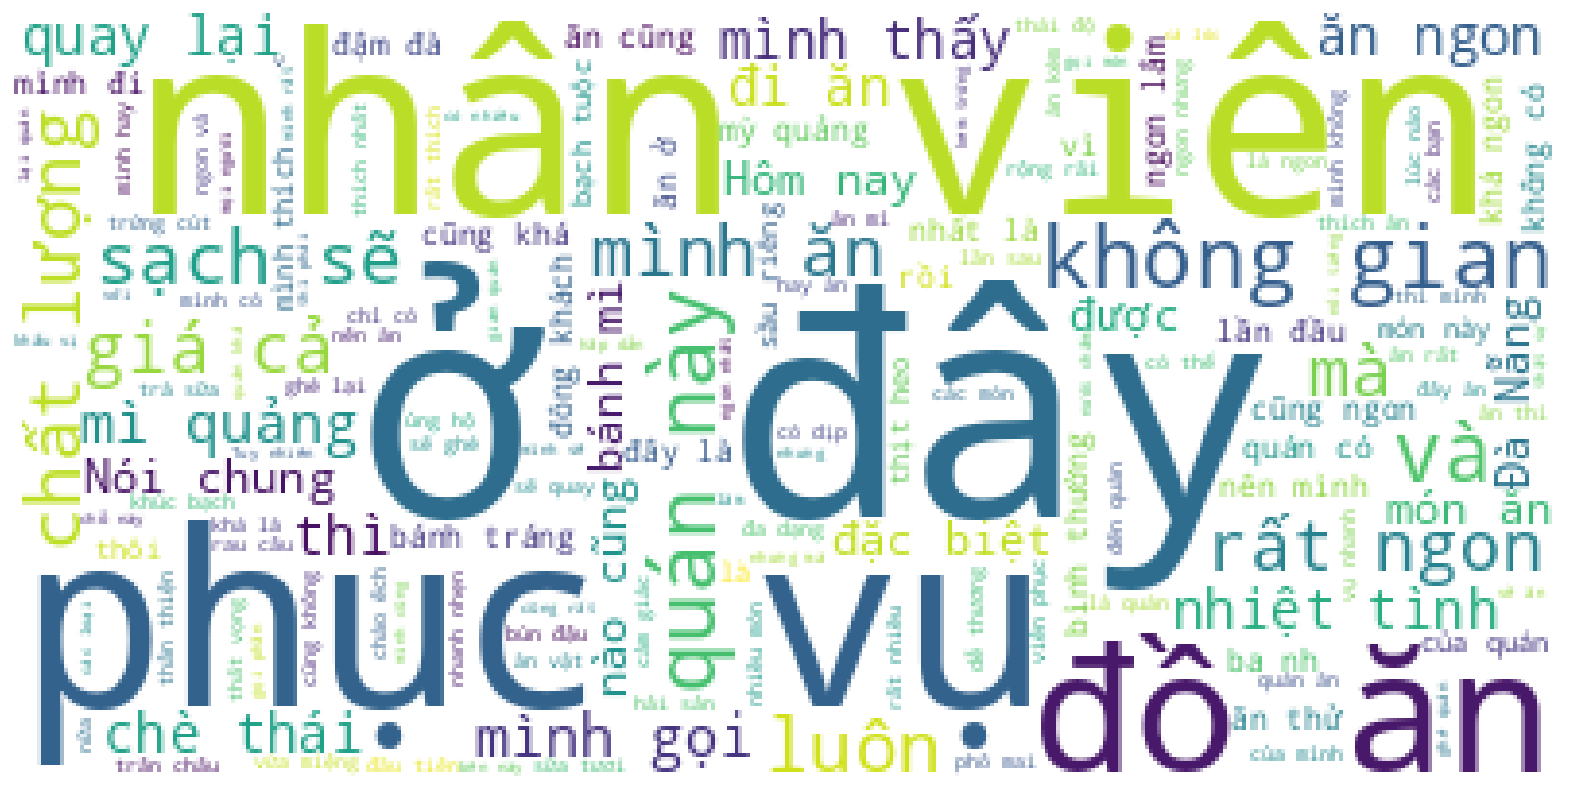

In [176]:
plot_wordcloud(joined_sentences)

In [177]:
negative = df[df['Label'] == 1]
positive = df[df["Label"] == 0]

negative_sentences = " ".join(negative['Review'].tolist())
positive_sentences = " ".join(positive['Review'].tolist())

- <i>WordCloud của các bình luận tiêu cực</i>

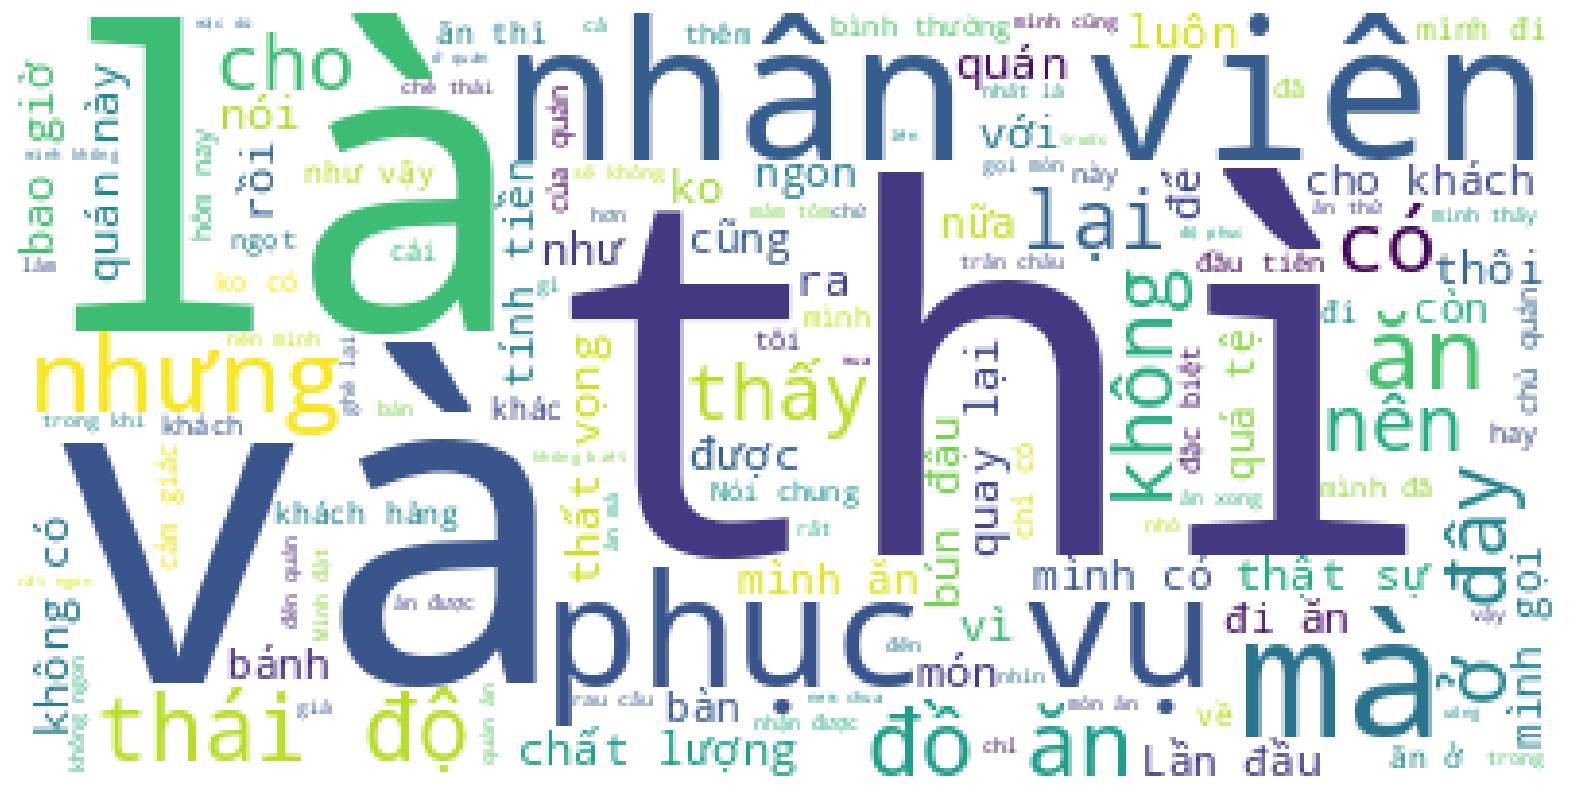

In [178]:
plot_wordcloud(negative_sentences)

- <i>WordCloud của các bình luận tích cực</i>

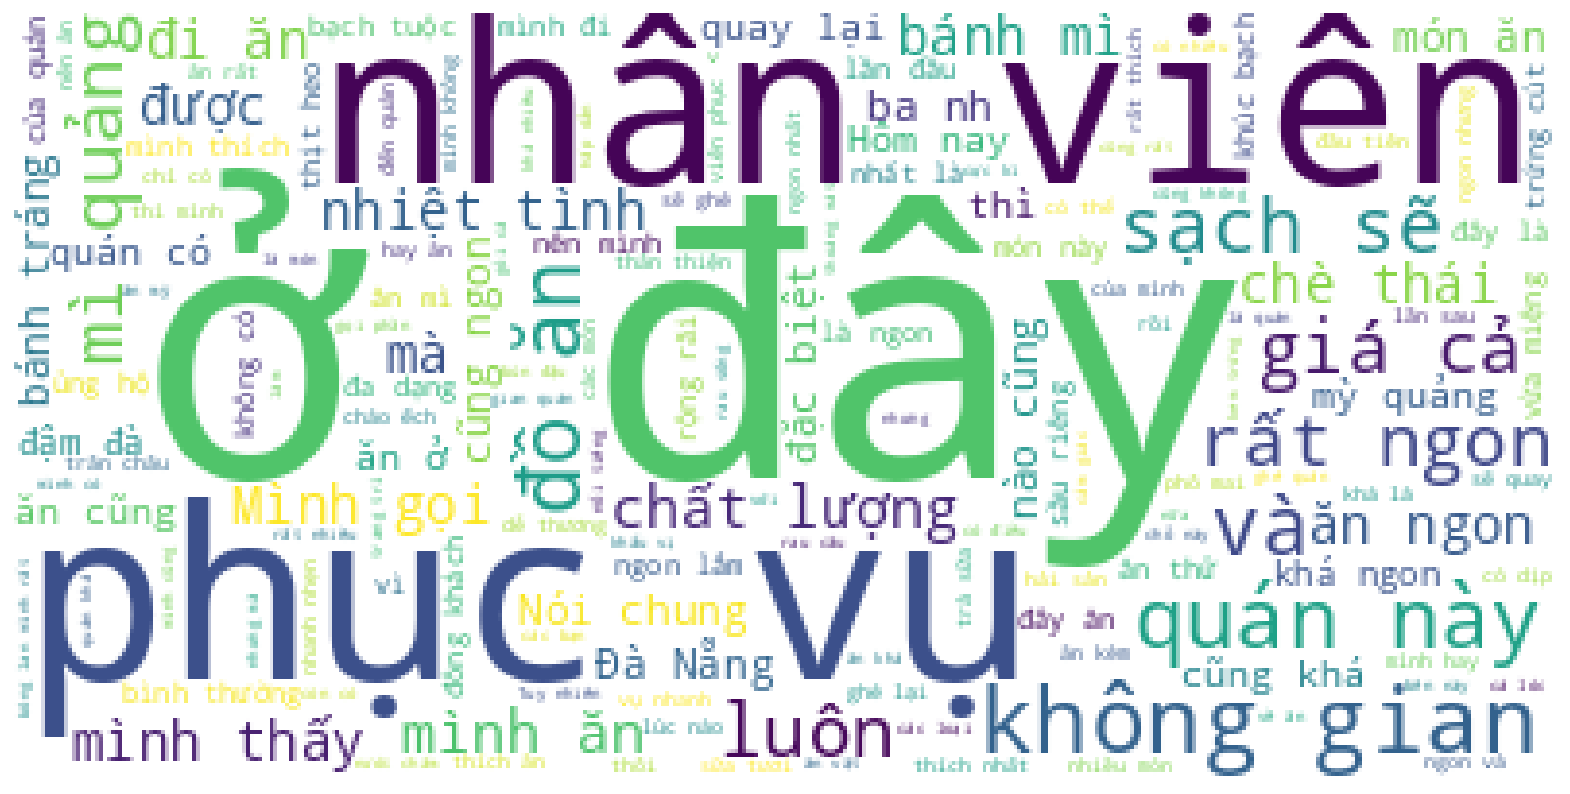

In [179]:
plot_wordcloud(positive_sentences)

### WordCloud sau khi tiền xử lý

Hàm tiền xử lý chuỗi

In [180]:
def tokenize_vietnamese_text(text):
    tokens = ViTokenizer.tokenize(text)
    return tokens


def get_stopwords(url):
    with open(url, 'r+', encoding='utf8') as file:
        stopwords = file.readlines()
        return set(stopwords)
    
    
stopwords = get_stopwords('vietnamese_stopwords_dash.txt')
def review_cleaning(message):
    # chuyển hết chuỗi sang chữ thường
    message = message.lower()
    
    # xoá các kí tự đặc biệt
    removed_punc_str = [char for char in message if char not in string.punctuation]
    removed_punc_str = ''.join(removed_punc_str)

    # tách các từ ghép
    removed_punc_str = tokenize_vietnamese_text(removed_punc_str)

    # xoá các stopwords
    clean_removed_punc_str = [word for word in removed_punc_str.split() if word.lower() not in stopwords]
    return clean_removed_punc_str

In [181]:
def list_to_str(message):
    return " ".join(message)

In [182]:
clean_df = pd.DataFrame(df['Review'].apply(review_cleaning))
clean_df['Review'] = clean_df['Review'].apply(list_to_str)
clean_df['Label'] = df['Label']

clean_sentences = " ".join(clean_df['Review'].tolist())

In [183]:
print(clean_df['Review'])

0       cháo ếch đậm_đà cơm thì không đặc_sắc mấy chủ ...
1       quán này mình cũng hay order lắm menu quán cũn...
2       cháo thịt bò 30k đang mệt người vì thời_tiết đ...
3       shinshu đã chuyển qua nguỹen hoàng vị_trí cũng...
4       chất_lượng menu đa_dạng nhiều lựa_chọn từ hươn...
                              ...                        
8451    đc lái_xe giới_thiệu cho ăn nhưng cảm_thấy cũn...
8452    quán ăn mình search trên mạng quán khá nôi tie...
8453    là 1 quán nổi_tiếng về mì quảng nhưng so với t...
8454                                             khá ngon
8455    tô mỳ quảng nhìn rất bắt_mắt nhưng không hợp_k...
Name: Review, Length: 8456, dtype: object


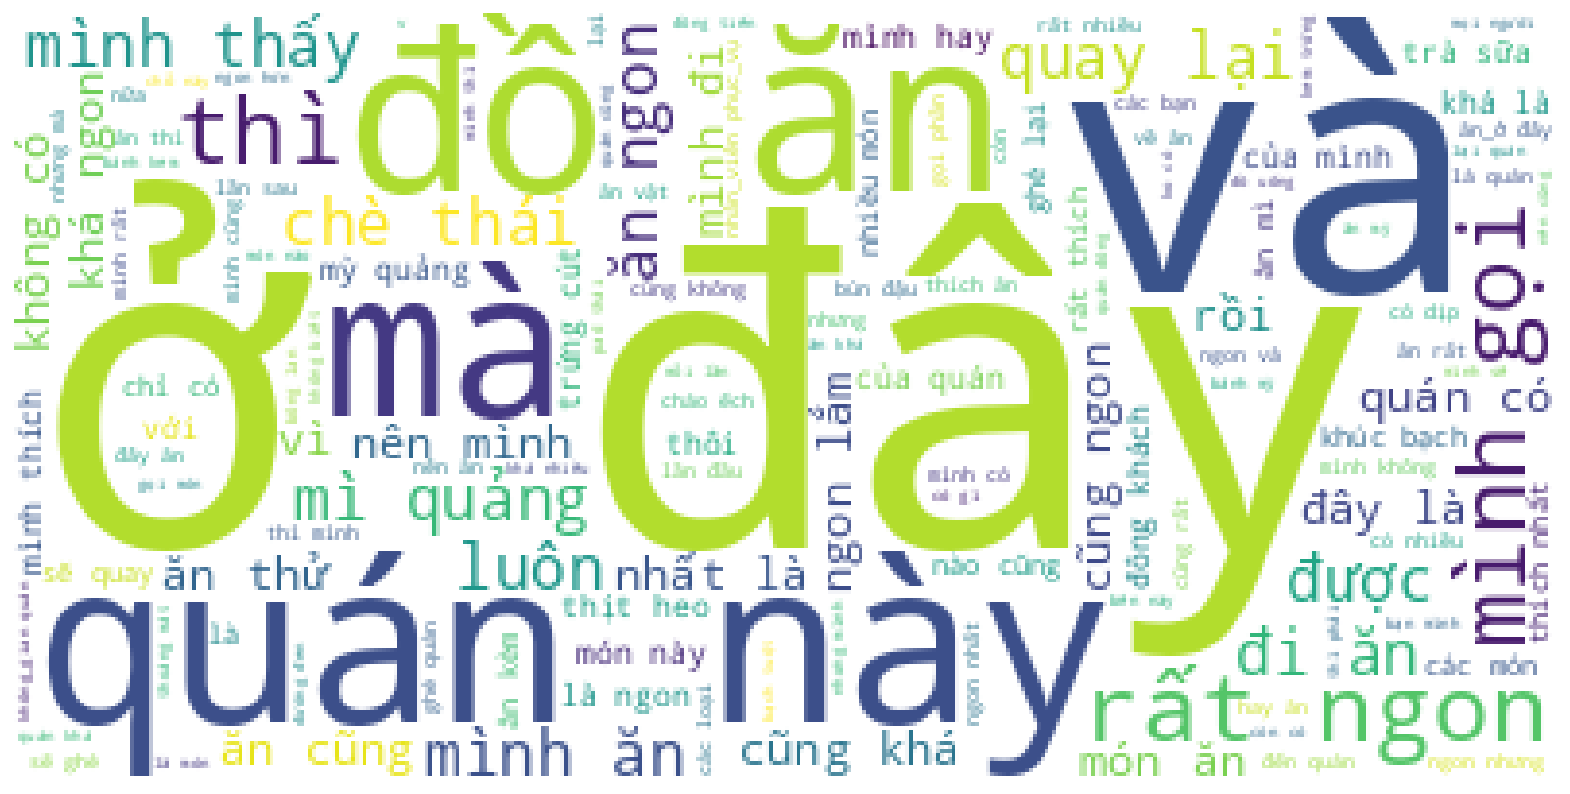

In [184]:
plot_wordcloud(clean_sentences)

In [185]:
clean_negative = clean_df[clean_df['Label'] == 1]
clean_positive = clean_df[clean_df['Label'] == 0]

clean_negative_sentences = " ".join(clean_negative['Review'].tolist())
clean_positive_sentences = " ".join(clean_positive['Review'].tolist())

- <i>WordCloud của các bình luận tiêu cực</i>

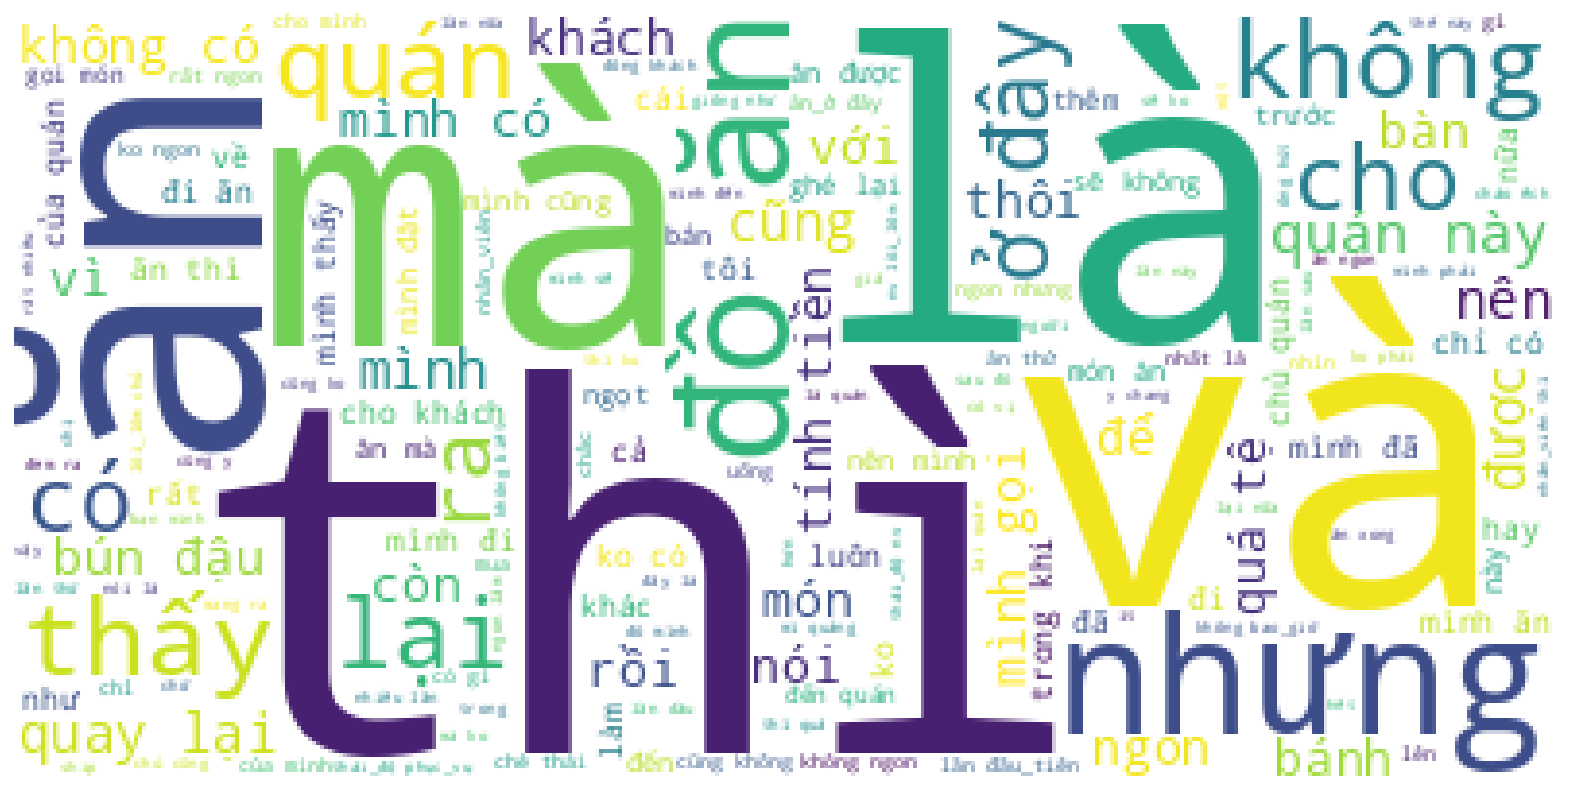

In [186]:
plot_wordcloud(clean_negative_sentences)

- <i>WordCloud của các bình luận tích cực</i>

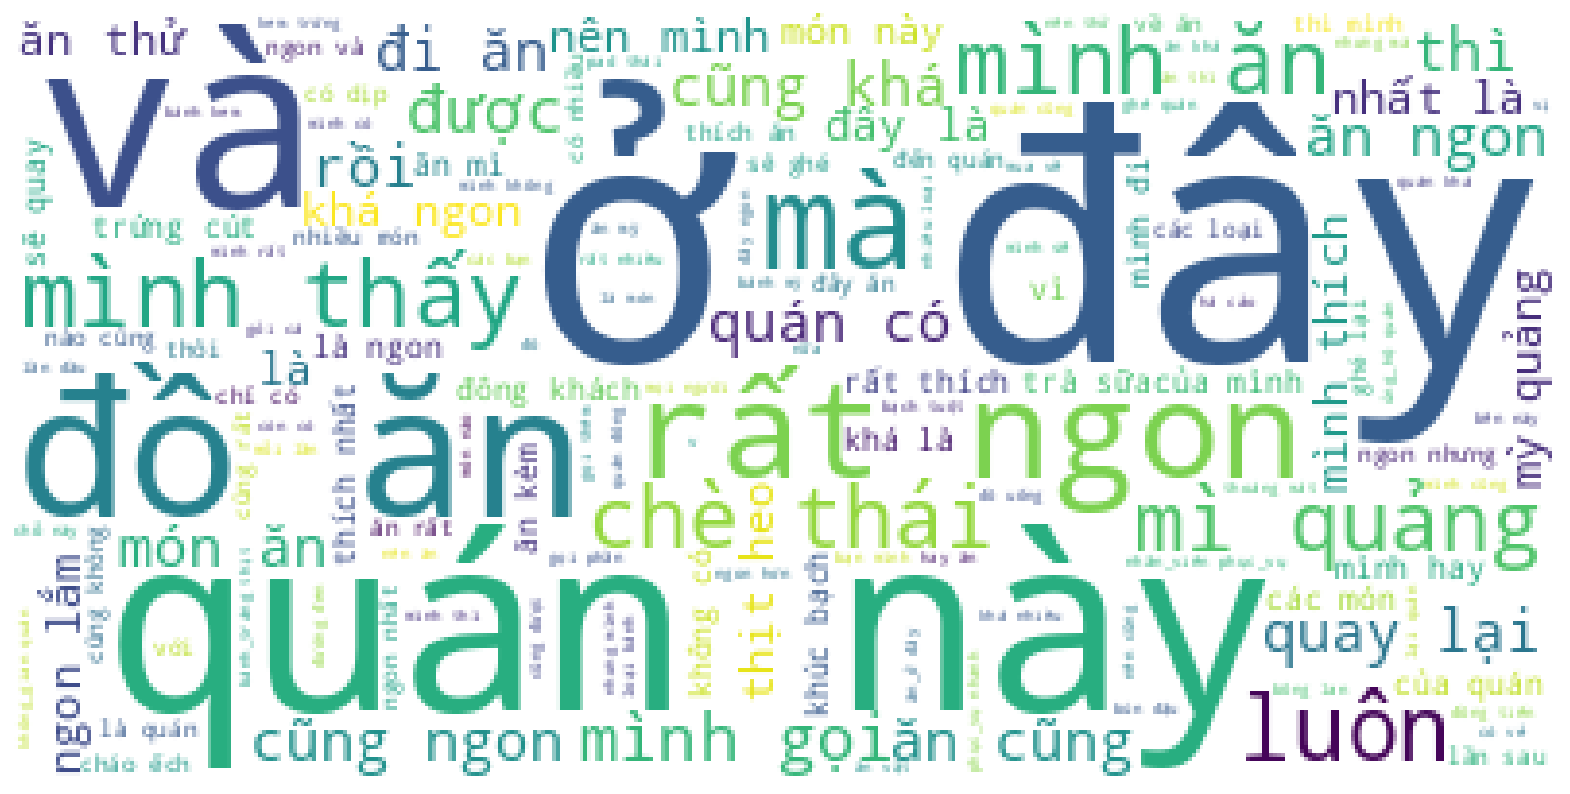

In [187]:
plot_wordcloud(clean_positive_sentences)

## Vector hoá văn bản và trực quan hoá dữ liệu

### CountVectorizer

<i>Áp dụng countvectorizer để vector hoá văn bản</i>
<br>
- Count_matrix có số chiều là 4822 (bằng với số từ vựng của tập dữ liệu vào)
- Count_matrix có số hàng là 1181 (bằng với số tập mẫu văn bản)

In [188]:
# Áp dụng vector
vectorizer = CountVectorizer(analyzer=review_cleaning)
count_matrix = vectorizer.fit_transform(df['Review'])
count_matrix

<8456x7833 sparse matrix of type '<class 'numpy.int64'>'
	with 440618 stored elements in Compressed Sparse Row format>

<i>Áp dụng t-SNE giảm chiều dữ liệu để trực quán hoá lên đồ thị 3 chiều</i>

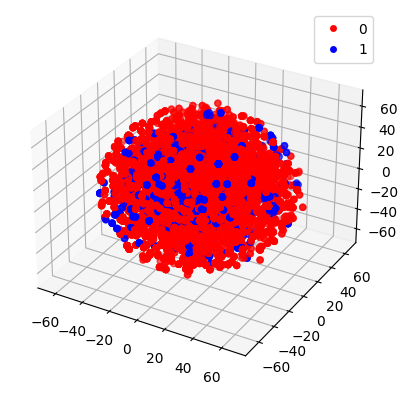

In [189]:
tsne = TSNE(n_components=3, random_state=42)
count_matrix_3d = tsne.fit_transform(count_matrix.toarray())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Visualize the data in 3D with colors based on the 'label' column
scatter = ax.scatter(count_matrix_3d[:, 0], count_matrix_3d[:, 1], count_matrix_3d[:, 2], c=df['Label'].map({0: 'red', 1: 'blue'}))

# Tạo legend cho nhãn
legend_labels = [0, 1]
legend_handles = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, label=label) for label, color in zip(legend_labels, ['red', 'blue'])]
ax.legend(handles=legend_handles, labels=legend_labels)

plt.show()

### TfidfVectorizer

<i>Áp dụng tfidfvectorizer để vector hoá văn bản</i>
<br>
- count_matrix có số chiều là 4822 (bằng với số từ vựng của tập dữ liệu vào)
- count_matrix có số hàng là 1181 (bằng với số tập mẫu văn bản)

In [190]:
# Create a CountVectorizer object and apply it to the 'review' column
vectorizer = TfidfVectorizer(analyzer=review_cleaning)
count_matrix = vectorizer.fit_transform(df['Review'])
count_matrix

<8456x7833 sparse matrix of type '<class 'numpy.float64'>'
	with 440618 stored elements in Compressed Sparse Row format>

<i>Áp dụng t-SNE giảm chiều dữ liệu để trực quán hoá lên đồ thị 3 chiều</i>

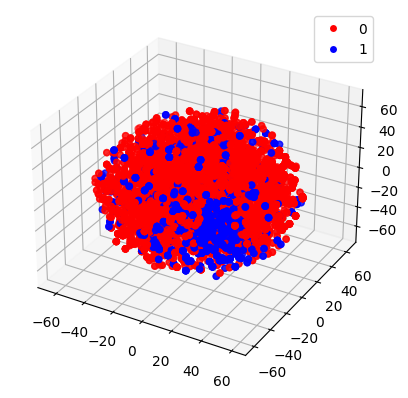

In [191]:

tsne = TSNE(n_components=3, random_state=42)
count_matrix_3d = tsne.fit_transform(count_matrix.toarray())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(count_matrix_3d[:, 0], count_matrix_3d[:, 1], count_matrix_3d[:, 2], c=df['Label'].map({0: 'red', 1: 'blue'}))

# Tạo legend cho nhãn
legend_labels = [0, 1]
legend_handles = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, label=label) for label, color in zip(legend_labels, ['red', 'blue'])]
ax.legend(handles=legend_handles, labels=legend_labels)

plt.show()

## Huấn luyện mô hình

In [192]:
def plot_confusion_matrix(x_test, y_test, model:GridSearchCV):
    # Dự đoán tập test
    y_pred = model.predict(x_test)

    # plot ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    print(classification_report(y_test, y_pred))


def train_model(vectorizer, classifier, x, y, cv=5):
    # Tạo pipeline
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])

    # cross_validate để dự đoán độ chính xác khi train
    y_pred = cross_val_predict(pipeline, x, y, cv=cv)
    accu = accuracy_score(y, y_pred)
    print('Accuracy score: {}'.format(accu))
    # cm = confusion_matrix(y, y_pred)
    # sns.heatmap(cm, annot=True, fmt='d')
    # print(classification_report(y, y_pred))
    return pipeline.fit(x, y)


def train_model_with_hyperparameters(vectorizer, classifier, x, y, cv=5):
    # Tạo pipeline
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])

    # Kiểm tra mô hình chọn để lựa chọn đúng bộ siêu tham số
    if isinstance(classifier, MultinomialNB):
        para_grid = {
            'classifier__alpha': [0.1, 0.5, 1.0],
            'classifier__fit_prior': [True, False]
        }
        columns = ['rank_test_score', 'mean_test_score', 'param_classifier__alpha','param_classifier__fit_prior']
    # thêm hyperparameters sau tuỳ theo mô hình lựa chọn
    else:
        para_grid = {
            'classifier__penalty': ['l1', 'l2'],
            'classifier__C': [1.0, 0.1, 0.01, 0.001]
        }
        columns = ['rank_test_score', 'mean_test_score', 'param_classifier__penalty','param_classifier__C']

    # Tìm kiếm bộ tham số tối ưu cho mô hình
    grid_search = GridSearchCV(pipeline, param_grid=para_grid, scoring='accuracy', cv=cv)

    search_result = grid_search.fit(x, y)
    result = pd.DataFrame(search_result.cv_results_, columns=columns).sort_values(by='rank_test_score')
    print("Best score: {} with hyperparameters {}".format(search_result.best_score_, search_result.best_params_))

    # Trả về kết quả, lần lượt và mô hình đã train và kết quả khi train với từng bộ tham số
    return search_result, result

### Huấn luyện trên small data

In [ ]:
# Đọc dữ liệu từ small data
small_df = pd.read_csv('small_data.csv')
small_df['Label'] = small_df['Point'].apply(lambda point: 0 if point >= 6 else 1)
x = small_df['Review']
y = small_df['Label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)

#### Mô hình Naive Bayes

##### CountVectorizer làm input

###### Không dùng hyperparameters

In [194]:
train_model(CountVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)

Accuracy score: 0.94272681196148


Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function review_cleaning at 0x00000206700D5D30>)),
                ('classifier', MultinomialNB())])

###### Có dùng hyperparameters

In [195]:
model, result = train_model_with_hyperparameters(CountVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)
result.head()

Best score: 0.954890938064015 with hyperparameters {'classifier__alpha': 0.1, 'classifier__fit_prior': True}


,rank_test_score,mean_test_score,param_classifier__alpha,param_classifier__fit_prior
0,1,0.954891,0.1,True
1,2,0.949483,0.1,False
2,3,0.948133,0.5,True
3,4,0.944078,0.5,False
4,5,0.942727,1.0,True


<b><i>Nhận xét</i></b>: Bằng cách lựa chọn siêu tham số thì độ chính xác của thuật toán tăng 1,45%, từ 91,16 lên 92,61% 

###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2127
           1       0.91      0.81      0.86       410

    accuracy                           0.96      2537
   macro avg       0.94      0.90      0.92      2537
weighted avg       0.96      0.96      0.96      2537



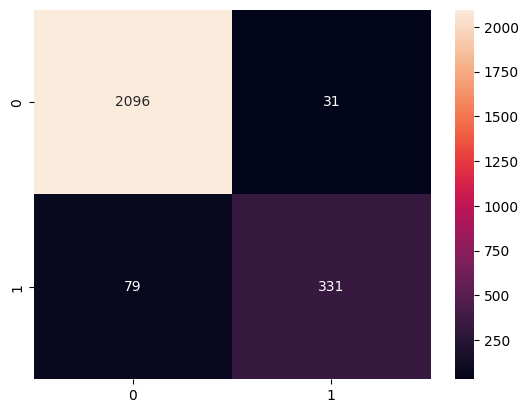

In [196]:
plot_confusion_matrix(x_test, y_test, model)

##### TfidfVectorizer làm input

###### Không dùng hyperparameters

In [198]:
train_model(TfidfVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)

Accuracy score: 0.8633215070113195


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function review_cleaning at 0x00000206700D5D30>)),
                ('classifier', MultinomialNB())])

###### Có dùng hyperparameters

In [199]:
model, result = train_model_with_hyperparameters(TfidfVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)
result.head()

Best score: 0.952018745287976 with hyperparameters {'classifier__alpha': 0.1, 'classifier__fit_prior': False}


,rank_test_score,mean_test_score,param_classifier__alpha,param_classifier__fit_prior
1,1,0.952019,0.1,False
0,2,0.948977,0.1,True
3,3,0.940867,0.5,False
5,4,0.917046,1.0,False
2,5,0.907248,0.5,True


###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2127
           1       0.84      0.85      0.85       410

    accuracy                           0.95      2537
   macro avg       0.91      0.91      0.91      2537
weighted avg       0.95      0.95      0.95      2537



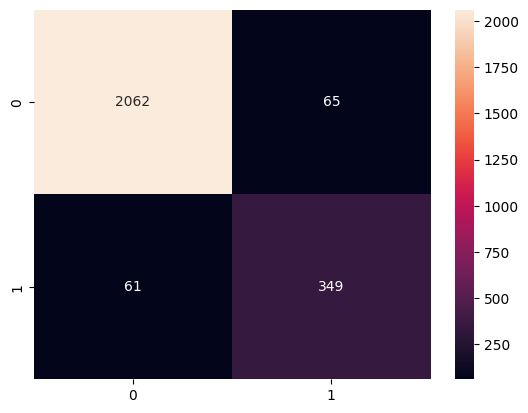

In [200]:
plot_confusion_matrix(x_test, y_test, model)

#### Mô hình Support Vector Machine

##### CountVectorizer làm input

###### Không dùng hyperparameters

In [201]:
train_model(CountVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)

Accuracy score: 0.975333671228248


Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function review_cleaning at 0x00000206700D5D30>)),
                ('classifier', LinearSVC(dual=False))])

###### Có dùng hyperparameters

In [202]:
model, result = train_model_with_hyperparameters(CountVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)
result.head()

Best score: 0.9761778631970939 with hyperparameters {'classifier__C': 0.1, 'classifier__penalty': 'l2'}


,rank_test_score,mean_test_score,param_classifier__penalty,param_classifier__C
3,1,0.976178,l2,0.1
1,2,0.975334,l2,1.0
0,3,0.973813,l1,1.0
5,4,0.961985,l2,0.01
2,5,0.953539,l1,0.1


###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2127
           1       0.98      0.92      0.95       410

    accuracy                           0.98      2537
   macro avg       0.98      0.96      0.97      2537
weighted avg       0.98      0.98      0.98      2537



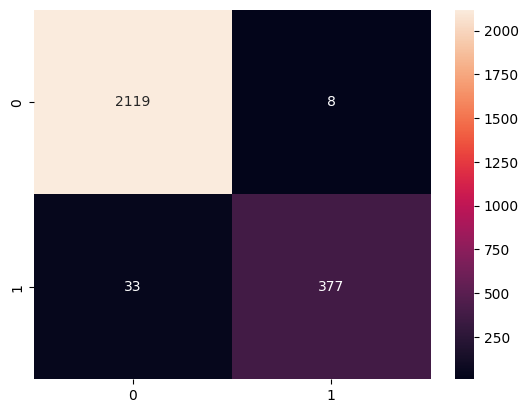

In [203]:
plot_confusion_matrix(x_test, y_test, model)

##### TfidfVectorizer làm input

###### Không dùng hyperparameters

In [204]:
train_model(TfidfVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)

Accuracy score: 0.979726305119108


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function review_cleaning at 0x00000206700D5D30>)),
                ('classifier', LinearSVC(dual=False))])

###### Có dùng hyperparameters

In [205]:
model, result = train_model_with_hyperparameters(TfidfVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)
result.head()

Best score: 0.9797261600146216 with hyperparameters {'classifier__C': 1.0, 'classifier__penalty': 'l2'}


,rank_test_score,mean_test_score,param_classifier__penalty,param_classifier__C
1,1,0.979726,l2,1.0
0,2,0.968744,l1,1.0
3,3,0.940700,l2,0.1
2,4,0.884778,l1,0.1
5,5,0.838824,l2,0.01


###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2127
           1       0.98      0.92      0.95       410

    accuracy                           0.98      2537
   macro avg       0.98      0.96      0.97      2537
weighted avg       0.98      0.98      0.98      2537



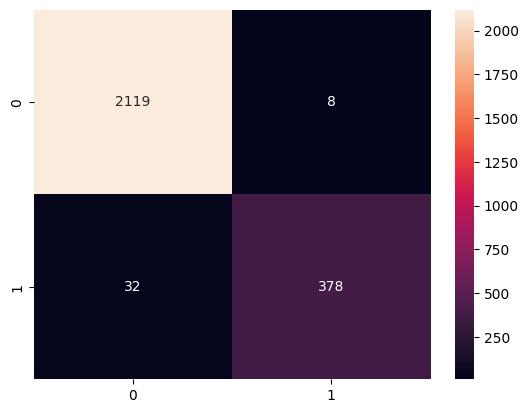

In [206]:
plot_confusion_matrix(x_test, y_test, model)

### Huấn luyện trên big data

In [ ]:
# Đọc dữ liệu từ small data
big_df = pd.read_csv('big_data.csv')
big_df['Label'] = big_df['Point'].apply(lambda point: 0 if point >= 6 else 1)
x = big_df['Review']
y = big_df['Label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)

#### Mô hình Naive Bayes

##### CountVectorizer làm input

###### Không dùng hyperparameters

In [ ]:
train_model(CountVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)

Accuracy score: 0.94272681196148


Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function review_cleaning at 0x00000206700D5D30>)),
                ('classifier', MultinomialNB())])

###### Có dùng hyperparameters

In [ ]:
model, result = train_model_with_hyperparameters(CountVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)
result.head()

Best score: 0.954890938064015 with hyperparameters {'classifier__alpha': 0.1, 'classifier__fit_prior': True}


,rank_test_score,mean_test_score,param_classifier__alpha,param_classifier__fit_prior
0,1,0.954891,0.1,True
1,2,0.949483,0.1,False
2,3,0.948133,0.5,True
3,4,0.944078,0.5,False
4,5,0.942727,1.0,True


<b><i>Nhận xét</i></b>: Bằng cách lựa chọn siêu tham số thì độ chính xác của thuật toán tăng 1,45%, từ 91,16 lên 92,61% 

###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2127
           1       0.91      0.81      0.86       410

    accuracy                           0.96      2537
   macro avg       0.94      0.90      0.92      2537
weighted avg       0.96      0.96      0.96      2537



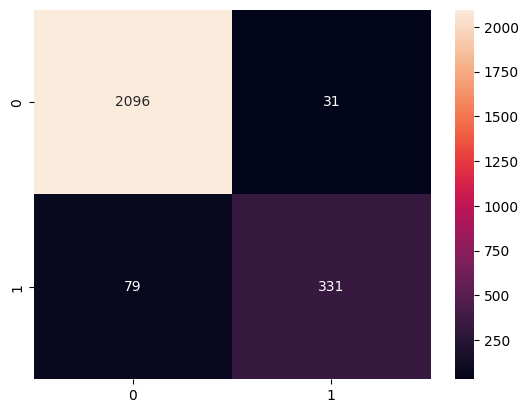

In [ ]:
plot_confusion_matrix(x_test, y_test, model)

##### TfidfVectorizer làm input

###### Không dùng hyperparameters

In [ ]:
train_model(TfidfVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)

Accuracy score: 0.8633215070113195


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function review_cleaning at 0x00000206700D5D30>)),
                ('classifier', MultinomialNB())])

###### Có dùng hyperparameters

In [ ]:
model, result = train_model_with_hyperparameters(TfidfVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)
result.head()

Best score: 0.952018745287976 with hyperparameters {'classifier__alpha': 0.1, 'classifier__fit_prior': False}


,rank_test_score,mean_test_score,param_classifier__alpha,param_classifier__fit_prior
1,1,0.952019,0.1,False
0,2,0.948977,0.1,True
3,3,0.940867,0.5,False
5,4,0.917046,1.0,False
2,5,0.907248,0.5,True


###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2127
           1       0.84      0.85      0.85       410

    accuracy                           0.95      2537
   macro avg       0.91      0.91      0.91      2537
weighted avg       0.95      0.95      0.95      2537



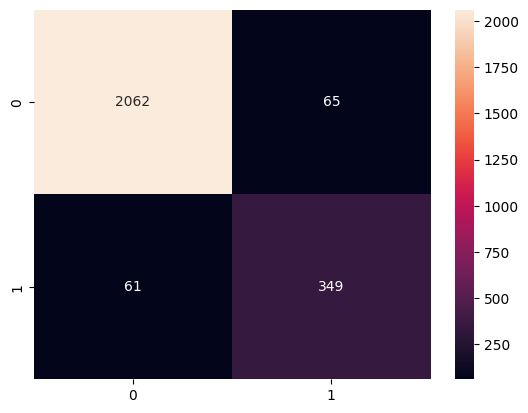

In [ ]:
plot_confusion_matrix(x_test, y_test, model)

#### Mô hình Support Vector Machine

##### CountVectorizer làm input

###### Không dùng hyperparameters

In [ ]:
train_model(CountVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)

Accuracy score: 0.975333671228248


Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function review_cleaning at 0x00000206700D5D30>)),
                ('classifier', LinearSVC(dual=False))])

###### Có dùng hyperparameters

In [ ]:
model, result = train_model_with_hyperparameters(CountVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)
result.head()

Best score: 0.9761778631970939 with hyperparameters {'classifier__C': 0.1, 'classifier__penalty': 'l2'}


,rank_test_score,mean_test_score,param_classifier__penalty,param_classifier__C
3,1,0.976178,l2,0.1
1,2,0.975334,l2,1.0
0,3,0.973813,l1,1.0
5,4,0.961985,l2,0.01
2,5,0.953539,l1,0.1


###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2127
           1       0.98      0.92      0.95       410

    accuracy                           0.98      2537
   macro avg       0.98      0.96      0.97      2537
weighted avg       0.98      0.98      0.98      2537



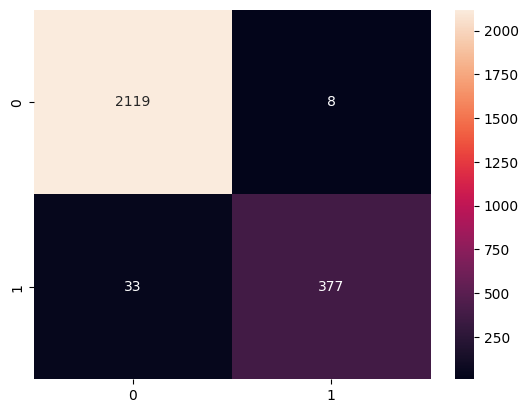

In [ ]:
plot_confusion_matrix(x_test, y_test, model)

##### TfidfVectorizer làm input

###### Không dùng hyperparameters

In [ ]:
train_model(TfidfVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)

Accuracy score: 0.979726305119108


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function review_cleaning at 0x00000206700D5D30>)),
                ('classifier', LinearSVC(dual=False))])

###### Có dùng hyperparameters

In [ ]:
model, result = train_model_with_hyperparameters(TfidfVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)
result.head()

Best score: 0.9797261600146216 with hyperparameters {'classifier__C': 1.0, 'classifier__penalty': 'l2'}


,rank_test_score,mean_test_score,param_classifier__penalty,param_classifier__C
1,1,0.979726,l2,1.0
0,2,0.968744,l1,1.0
3,3,0.940700,l2,0.1
2,4,0.884778,l1,0.1
5,5,0.838824,l2,0.01


###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2127
           1       0.98      0.92      0.95       410

    accuracy                           0.98      2537
   macro avg       0.98      0.96      0.97      2537
weighted avg       0.98      0.98      0.98      2537



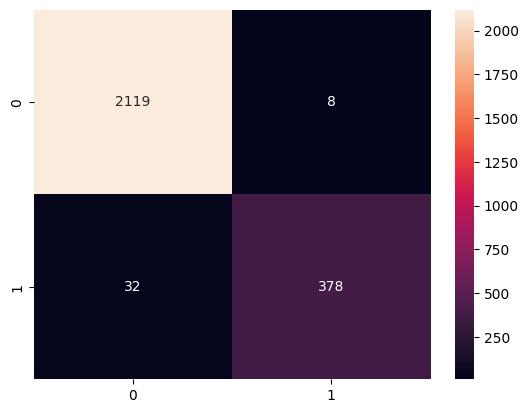

In [ ]:
plot_confusion_matrix(x_test, y_test, model)